#GIS-Part Ad Vacuum

Quellen:

1.   https://realpython.com/api-integration-in-python/
2.   https://openweathermap.org/current#geo
3.   https://docs.python-requests.org/de/latest/user/quickstart.html
4.   https://www.geeksforgeeks.org/read-json-file-using-python/

## Import Libraries

In [ ]:
#Get all preinstalled modules
%pip list

In [ ]:
! git clone https://github.com/Turbo87/utm

In [ ]:
%pip install /content/utm/

In [59]:
%pip install geopandas

     |████████████████████████████████| 1.0MB 4.4MB/s 
     |████████████████████████████████| 6.5MB 12.3MB/s 
     |████████████████████████████████| 15.3MB 199kB/s 


In [81]:
%pip install geojson

In [2]:
import pandas as pd
pd.__version__

'1.1.5'

In [3]:
import requests
requests.__version__

'2.23.0'

In [4]:
import json
json.__version__

'2.0.9'

In [5]:
import numpy as np
np.__version__

'1.19.5'

## API Call and Response

In [6]:
#Salzburg
input_coords = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[13.033218383789062,47.79355334155344]}}]}'
#Hallein
#testcoords = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[13.096046447753906,47.69104578658821]}}]}'
print(input_coords)

{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Point","coordinates":[13.033218383789062,47.79355334155344]}}]}


In [7]:
json_coords = json.loads(input_coords)
print(json.dumps(json_coords, indent=4, sort_keys=True))

{
    "features": [
        {
            "geometry": {
                "coordinates": [
                    13.033218383789062,
                    47.79355334155344
                ],
                "type": "Point"
            },
            "properties": {},
            "type": "Feature"
        }
    ],
    "type": "FeatureCollection"
}


In [8]:
lat = json_coords["features"][0]["geometry"]["coordinates"][1]
print(lat)
lon = json_coords["features"][0]["geometry"]["coordinates"][0]
print(lon)

47.79355334155344
13.033218383789062


In [9]:
#lat = '47.7994'
#lon = '13.044'
#resp = requests.get('http://api.openweathermap.org/data/2.5/weather?q=Salzburg&appid=ID')
resp = requests.get('http://api.openweathermap.org/data/2.5/weather?lat=' + str(lat) + '&lon=' + str(lon) + '&appid=')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

In [10]:
print(resp.text)

{"coord":{"lon":13.0332,"lat":47.7936},"weather":[{"id":802,"main":"Clouds","description":"scattered clouds","icon":"03d"}],"base":"stations","main":{"temp":282.45,"feels_like":280.24,"temp_min":281.48,"temp_max":283.15,"pressure":1020,"humidity":76},"visibility":10000,"wind":{"speed":4.12,"deg":200},"clouds":{"all":40},"dt":1619111234,"sys":{"type":1,"id":6877,"country":"AT","sunrise":1619064331,"sunset":1619114809},"timezone":7200,"id":2766824,"name":"Salzburg","cod":200}


##Prettify JSON and get Wind Information

In [11]:
parsed = json.loads(resp.text)
print(json.dumps(parsed, indent=4, sort_keys=True))

{
    "base": "stations",
    "clouds": {
        "all": 40
    },
    "cod": 200,
    "coord": {
        "lat": 47.7936,
        "lon": 13.0332
    },
    "dt": 1619111234,
    "id": 2766824,
    "main": {
        "feels_like": 280.24,
        "humidity": 76,
        "pressure": 1020,
        "temp": 282.45,
        "temp_max": 283.15,
        "temp_min": 281.48
    },
    "name": "Salzburg",
    "sys": {
        "country": "AT",
        "id": 6877,
        "sunrise": 1619064331,
        "sunset": 1619114809,
        "type": 1
    },
    "timezone": 7200,
    "visibility": 10000,
    "weather": [
        {
            "description": "scattered clouds",
            "icon": "03d",
            "id": 802,
            "main": "Clouds"
        }
    ],
    "wind": {
        "deg": 200,
        "speed": 4.12
    }
}


In [12]:
wind = parsed["wind"]
wind_speed = parsed["wind"]["speed"]
wind_dir = parsed["wind"]["deg"]
print(wind_speed)
print(wind_dir)

4.12
200


##Create wind cones

https://gis.stackexchange.com/questions/326681/getting-geometries-of-hurricanes-cone-of-uncertainty-using-shapely
https://link.springer.com/article/10.1007/s13595-019-0829-8
https://www.dwd.de/DE/service/lexikon/Functions/glossar.html?lv2=102936&lv3=103182


In [13]:
#Recalculation of movement in km
#Wind speed is calculated from m/s to km/h via *3.6
#Fires move 1/10th the km/h of the wind speed (see paper above), thus /10
wind_speed_move = (float(wind_speed)*3.6)/10 
print(wind_speed_move)

1.4832


In [14]:
#Recalculation from geographic to arithmetic degrees
#+180 because the fire goes away from the wind, not into the same direction
dir_new = (-(wind_dir+180)+450)%360
print(dir_new)

70


In [15]:
#Calculate x and y
dx=wind_speed_move*np.cos(np.radians(dir_new))
print(dx)
dy=wind_speed_move*np.sin(np.radians(dir_new))
print(dy)

0.507284276580632
1.3937520951496594


In [34]:
#Conversion to degrees latitude and longitude
#The approximate conversions are:
#Latitude: 1 deg = 110.574 km -> deg = x/110.574
#Longitude: 1 deg = 111.320*cos(latitude) km -> deg = x/111.320
import utm
print(utm.__version__)

#conversion to UTM ('meters')
utm_coords = utm.from_latlon(lat, lon)

#add x and y in meters
newlat=utm_coords[0]+(dx*1000)
newlon=utm_coords[1]+(dy*1000)

#Return to WGS84
pos2 = utm.to_latlon(newlat,newlon,utm_coords[2],utm_coords[3])
print(pos2)



0.7.0
(47.806202122023635, 13.039516260511878)


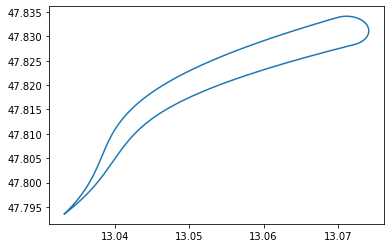

In [52]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
from scipy.interpolate import interp1d

# x, y: coords of forecast position
y = [lat, pos2[0],47.81765021489975,47.831134971598395]
x = [lon, pos2[1],13.046951293945312,13.071155548095703]
# r: radius of uncertainty
r = [0, 0.001, 0.002, 0.003]
hours = [0, 1, 2, 3]
# interpolate
points_num = 100
interp_hours = np.linspace(min(hours), max(hours), points_num)
x = interp1d(hours, x, kind='cubic')(interp_hours)
y = interp1d(hours, y, kind='cubic')(interp_hours)
r = interp1d(hours, r, kind='linear')(interp_hours)
# make polygon
thetas = np.linspace(0, 2 * np.pi, 360)
polygon_x = x[:,None] + r[:,None] * np.sin(thetas)
polygon_y = y[:,None] + r[:,None] * np.cos(thetas)

# circles
ps = [Polygon(i) for i in np.dstack((polygon_x, polygon_y))]

# list of convex hulls of subsequent circles
n = range(len(ps)-1)
convex_hulls = [MultiPolygon([ps[i], ps[i+1]]).convex_hull for i in n]

# Final polygon
polygons = cascaded_union(convex_hulls)

x,y=polygons.exterior.xy
plt.plot(x,y)

In [89]:
#print(polygons)
from shapely import wkt
import geojson

#thewkt=wkt.dumps(polygons)
#thewkt
g1=wkt.loads(str(polygons))

g2=geojson.Feature(properties={"Name": "Betroffenheitspolygon"},geometry=g1)

g2.geometry
print(g2)
#print(json.dumps(g2, indent=4, sort_keys=True))

{"geometry": {"coordinates": [[[13.033218, 47.793553], [13.033518, 47.794002], [13.033804, 47.794446], [13.034077, 47.794885], [13.034338, 47.79532], [13.034587, 47.79575], [13.034824, 47.796176], [13.03505, 47.796597], [13.035265, 47.797014], [13.035471, 47.797426], [13.035666, 47.797835], [13.035852, 47.79824], [13.03603, 47.798641], [13.036199, 47.799039], [13.03636, 47.799431], [13.036514, 47.799822], [13.036662, 47.80021], [13.036802, 47.800594], [13.036937, 47.800974], [13.037067, 47.801355], [13.03719, 47.801727], [13.037311, 47.802105], [13.037424, 47.802472], [13.037537, 47.802846], [13.037645, 47.803211], [13.037751, 47.803575], [13.037855, 47.803943], [13.037957, 47.804309], [13.038058, 47.804674], [13.038158, 47.805037], [13.038257, 47.805398], [13.038356, 47.805758], [13.038454, 47.806117], [13.038554, 47.806474], [13.038655, 47.806831], [13.038757, 47.807186], [13.038762, 47.807204], [13.038866, 47.807559], [13.038972, 47.807913], [13.039082, 47.808267], [13.039088, 47.80

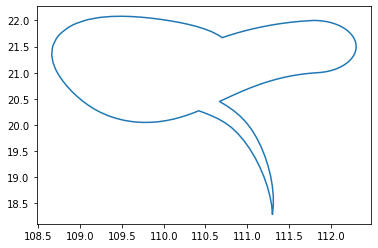

In [24]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
from scipy.interpolate import interp1d

# x, y: coords of forecast position
y = [18.3, 19.2, 20.0, 20.4, 20.7, 21.3, 21.6, 21.5, 20.8, 20.8, 21.5]
x = [111.3, 111.2, 110.9, 110.5, 110.2, 110.5, 110.0, 109.2, 109.4, 110.3, 111.8]
# r: radius of uncertainty
r = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5, 0.5]
hours = [0, 6, 12, 18, 24, 36, 48, 60, 72, 96, 120]
# interpolate
points_num = 100
interp_hours = np.linspace(min(hours), max(hours), points_num)
x = interp1d(hours, x, kind='cubic')(interp_hours)
y = interp1d(hours, y, kind='cubic')(interp_hours)
r = interp1d(hours, r, kind='linear')(interp_hours)
# make polygon
thetas = np.linspace(0, 2 * np.pi, 360)
polygon_x = x[:,None] + r[:,None] * np.sin(thetas)
polygon_y = y[:,None] + r[:,None] * np.cos(thetas)

# circles
ps = [Polygon(i) for i in np.dstack((polygon_x, polygon_y))]

# list of convex hulls of subsequent circles
n = range(len(ps)-1)
convex_hulls = [MultiPolygon([ps[i], ps[i+1]]).convex_hull for i in n]

# Final polygon
polygons = cascaded_union(convex_hulls)

x,y=polygons.exterior.xy
plt.plot(x,y)